# EMNIST Letters *Recognition* (0-9, A-Z and Space ~)

# 0. Load packages and co.

In [1]:
import numpy as np
import pandas as pd

import csv
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import random
import os
import datetime

from tensorflow import keras
from keras import models
from keras import layers
from keras.optimizers import RMSprop


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def img_show(img,colorbar=False):
    plt.figure(figsize=(10,8))
    plt.imshow(img,cmap='Greys_r')
    if colorbar:
        plt.colorbar()
    plt.show()

# 1. Load EMNIST balanced dataset
Introduced by https://arxiv.org/abs/1702.05373v1 downloaded from https://www.nist.gov/itl/iad/image-group/emnist-dataset 

## 1.1. Load the data

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Current DataSet Path
PATH = '/content/drive/MyDrive/upwork/11_alphabet_recognition'
%cd /content/drive/MyDrive/upwork/11_alphabet_recognition/

Mounted at /content/drive
/content/drive/MyDrive/upwork/11_alphabet_recognition


In [4]:
trainDataFile = './emnist-balanced-train.csv'
testDataFile = './emnist-balanced-test.csv'



Firstly, we need to load our data, notice that there is no column names in csv files and thus header should be set to `None`.

In [5]:
train=pd.read_csv(trainDataFile, header=None)
test = pd.read_csv(testDataFile, header=None)

In [6]:
print('Shape of EMNIST Digits train Data:')
print(train.shape)
print('Shape of the EMNIST Digits test Data: ')
print(test.shape)
print('Printing top 5 rows:')
test.head()

Shape of EMNIST Digits train Data:
(112800, 785)
Shape of the EMNIST Digits test Data: 
(18800, 785)
Printing top 5 rows:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


1 column for the label and then 28x28=784 columns for the pixels of the 28x28 images

## 1.2. Remove lowercase letters


You can skip this step if you want to detect lowercase letters. In our case, we bold text

wanna specialize our AI on digits and capital letters, that's why we're doing this 🙂. We take the first 36 classes. (we remove the last 11 classes that concerns lowercase letters. Cf the paper https://arxiv.org/abs/1702.05373v1 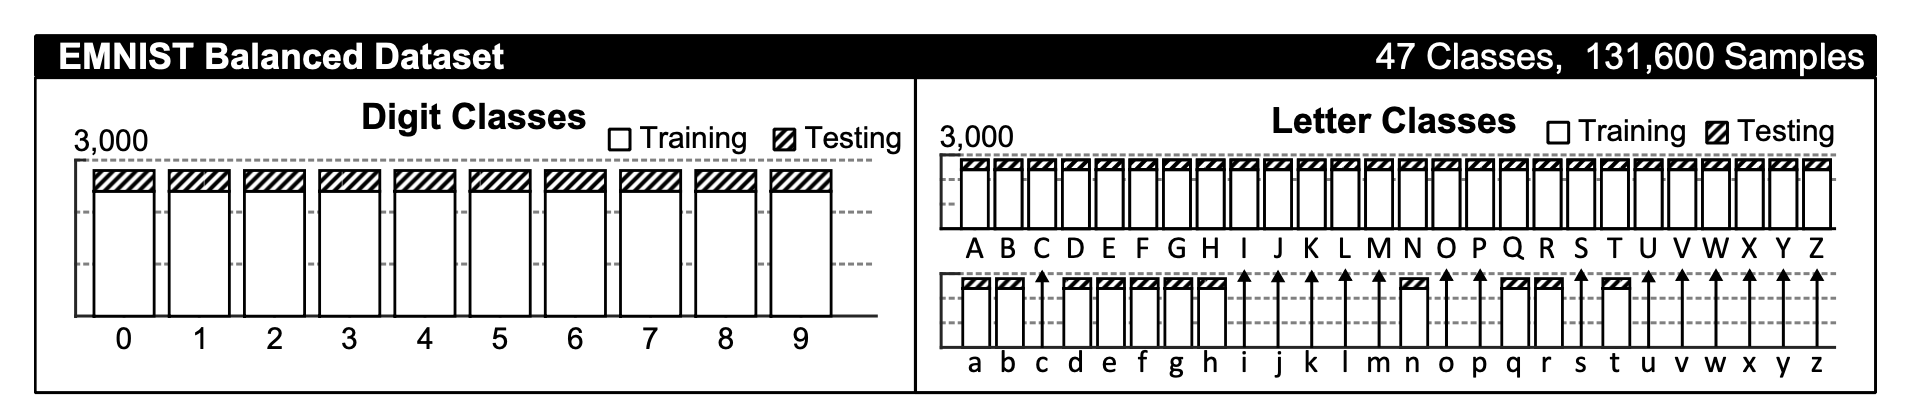

In [7]:
train = train[train[0]<= 35].reset_index(drop=True)
test = test[test[0]<= 35].reset_index(drop=True)


In [8]:
print(train.shape)
print(test.shape)

(86400, 785)
(14400, 785)


There are 131600/47 = 2800 samples per class. 86400/36 = 2400 samples per class in the training set and 400 samples per class in the testing set.

We need to add a 37th class (36 because of array indexing) for blank spaces that will be labelled as '~'. (at this step we should also add special characters like ' or - . TO DO LATER)



In [9]:
train_blanks = train.head(2400) * 0
train_blanks[0]=36

test_blanks = train.head(400) * 0
test_blanks[0]=36


In [10]:
train_blanks.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
train.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
86395,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3,0,0,0,...,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
86396,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
86397,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
86398,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
86399,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
train=train.append(train_blanks, ignore_index=True)
test=test.append(test_blanks, ignore_index=True)

In [13]:
print(train.shape)
print(test.shape)

(88800, 785)
(14800, 785)


In [14]:
train.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
88795,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
88796,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
88797,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
88798,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
88799,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
# train.head()
#For Digits
#eq_digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#characts = ['0','1','2','3','4','5','6','7','8','9','~']

#For Letters
#eq_digits = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,35, 36]
#characts = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','~']

#For Capital Letters & Digits
eq_digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,35, 36]
characts = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z', '~',]

ids = {'orig':eq_digits,
      'new': characts}
ids = dict(zip(ids['orig'], ids['new']))

# train[0]=train[0].replace(ids)
# test[0]=test[0].replace(ids)
# train.tail()

In [16]:
print(ids[10])
print(len(characts))
print(len(eq_digits))


A
37
37


In [17]:
test.iloc[[4399]]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
4399,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 1.3. Split data into x and y

Now split labels and images from original dataframe.

In [18]:
# x: data and y: labels
x_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
x_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

In [19]:
y_train.head()

0    15
1     4
2    26
3    32
4    20
Name: 0, dtype: int64

In [20]:
x_train.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 1.4. Store labels for later visualization

In [21]:
# store labels for visualization
train_labels = y_train
test_labels = y_test

In [22]:
train_labels

0        15
1         4
2        26
3        32
4        20
         ..
88795    36
88796    36
88797    36
88798    36
88799    36
Name: 0, Length: 88800, dtype: int64

## 1.5. One-hot encoding y

In [23]:
# # One hot encoding with `get_dummies()` 
# y_train = pd.get_dummies(y_train)
# y_train = y_train[characts] #to reorder columns correctly
# y_test = pd.get_dummies(y_test)
# y_test = y_test[characts] #to reorder columns correctly


In [24]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train, len(eq_digits))
y_test = np_utils.to_categorical(y_test, len(eq_digits))
print(y_train[0])
print(y_train.shape)
print(y_test.shape)




[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(88800, 37)
(14800, 37)


## 1.6 Turn df into np.arrays

Turn our Dataframes into numpy array and delete `train` and `test` to save up memory.

In [25]:
del train, test

## 1.7. Normalize and reshape x 

In [26]:
x_train.shape

(88800, 784)

In [27]:
# normalize
x_train = x_train/255
x_test = x_test/255

In [28]:
def transpose(image):
    image = image.reshape([28, 28])
    image = np.transpose(image) #flip+rot90
    return image.reshape([28 * 28])


In [29]:
# flip_and_rotate
x_train = np.apply_along_axis(transpose, 1, x_train)
x_test = np.apply_along_axis(transpose, 1, x_test)

In [30]:
x_train.shape

(88800, 784)

## 1.8. Verify we have imported the data correctly

In [31]:
# which sample to look at
samplenum = 1

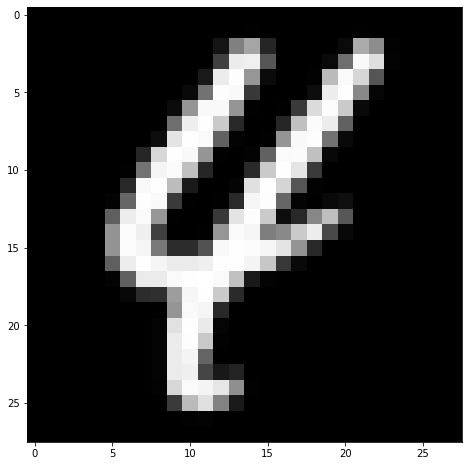

In [32]:
import matplotlib.pyplot as plt

img = x_train[samplenum].reshape([28, 28])

# visualize image
img_show(img)

In [33]:
# show label for sample image
y_train[samplenum][0]

0.0

In [34]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(88800, 784)
(88800, 37)
(14800, 784)
(14800, 37)


## 1.9. importing tensorflow and reshape 

In [35]:
%tensorflow_version 2.x
print(tf.__version__)

2.5.0


In [36]:
print(tf.reshape(x_test, [-1, 28, 28, 1])[0].shape)

(28, 28, 1)


In [37]:
x_train = tf.reshape(x_train, [-1, 28, 28, 1])
x_test = tf.reshape(x_test, [-1, 28, 28, 1])
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(88800, 28, 28, 1)
(88800, 37)
(14800, 28, 28, 1)
(14800, 37)


We're good!

# 2. Model EMNIST balanced

## 2.1. Model architecture + hyperparameters

In [38]:
# # Model 1

# model_best = models.Sequential()
# model_best.add( layers.Conv2D(10, 4, input_shape=(28,28,1), activation='relu') )
# model_best.add( layers.MaxPooling2D(2) )
# model_best.add( layers.Conv2D(20, 4, activation='relu') )
# model_best.add( layers.Flatten() )
# model_best.add( layers.Dropout(rate=0.5) )
# model_best.add( layers.Dense(100, activation='relu') )
# model_best.add( layers.Dense(10, activation='softmax') )

# model_best.summary()



#Model 2

model_best = models.Sequential()
model_best.add( layers.Conv2D(16, 4, input_shape=(28,28,1), activation='relu') )
model_best.add( layers.MaxPooling2D(2) )
model_best.add( layers.Conv2D(32, 4, activation='relu') )
model_best.add( layers.MaxPooling2D(2) )
model_best.add( layers.Flatten() )
model_best.add( layers.Dropout(0.4) )
model_best.add( layers.Dense(100, activation='relu') )
model_best.add( layers.Dense(len(eq_digits), activation='softmax') )

model_best.summary()



# #Model 3:

# model_best = models.Sequential()
# model_best.add( layers.Conv2D(32, 3, input_shape=(28,28,1), activation='relu') )
# model_best.add( layers.MaxPooling2D(2) )
# model_best.add( layers.Flatten(input_shape=(28,28,1)) )
# model_best.add( layers.Dense(512, activation='relu') )
# model_best.add( layers.Dense(128, activation='relu') )
# model_best.add( layers.Dense(10, activation='softmax') )

# model_best.summary()



# #Model 4

# model_best = models.Sequential()
# model_best.add( layers.Conv2D(32, 3, input_shape=(28,28,1), activation='relu') )
# model_best.add( layers.MaxPooling2D(2) )
# model_best.add( layers.Dropout(0.2) )
# model_best.add( layers.Conv2D(32, 3, input_shape=(28,28,1), activation='relu') )
# model_best.add( layers.MaxPooling2D(2) )
# model_best.add( layers.Flatten(input_shape=(28,28,1)) )
# model_best.add( layers.Dense(512, activation='relu') )
# model_best.add( layers.Dense(128, activation='relu') )
# model_best.add( layers.Dense(10, activation='softmax') )

# model_best.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 16)        272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 32)          8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               5

In [39]:
#Compile model
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)
# lossFunction = tf.keras.losses.CategoricalCrossentropy()
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=15)

# model.compile(optimizer=optimizer, 
#               loss=lossFunction,
#               metrics=['accuracy'])

#Compile model
model_best.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

In [40]:
# !pip install wandb -qqq

In [41]:
# import wandb
# # Log in to your W&B account
# wandb.login()

In [42]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# from wandb.keras import WandbCallback

In [43]:
# # construct the image generator for data augmentation
# data_aug = ImageDataGenerator(
# 	rotation_range=10,
# 	zoom_range=0.05,
# 	width_shift_range=0.1,
# 	height_shift_range=0.1,
# 	shear_range=0.15,
# 	horizontal_flip=False,
# 	fill_mode="nearest")

In [44]:
# wandb.init(
#       project="keras-one-charac-reco-test",
#       config={
#           "epochs": 100,
#           "batch_size": 256,
#       })
# config = wandb.config

# BS = config.batch_size
# EPOCHS = config.epochs

# model.fit(
#           data_aug.flow(x_train, y_train, batch_size=BS),
#           validation_data=(x_test, y_test),
#           steps_per_epoch=len(x_train) // BS,
#           epochs=EPOCHS,
#           callbacks= [early_stop, WandbCallback()])

# wandb.finish()

In [45]:
# TODO DO : try sweep to grid search the best hyperparameters
# https://colab.research.google.com/github/wandb/examples/blob/master/colabs/tensorflow/Hyperparameter_Optimization_in_TensorFlow_using_W%26B_Sweeps.ipynb

In [46]:
# Saving best model settings
SaveModelDir="EMNIST_Digits&Letters_Training"
checkpoint_path = SaveModelDir+"/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
metric = 'val_acc'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor=metric, save_weights_only=False, save_best_only = True, verbose=1)


#Save complete Model
model_best.save(SaveModelDir+"/Model_2_digits")

#model.save('/content/drive/My Drive/FD EDU Official/AI & Data Science/OCR/Upwork Mission/internal work done/my_model.h5')

INFO:tensorflow:Assets written to: EMNIST_Digits&Letters_Training/Model_2_digits/assets


## 2.2. Train the Model and save best Fine-Tuned Perameters

In [47]:
history_best = model_best.fit(x_train, y_train, validation_data=(x_test,y_test),  batch_size=200, epochs=100, callbacks=[cp_callback])

Epoch 1/100
444/444 [==============================] - 40s 7ms/step - loss: 1.1319 - acc: 0.6579 - val_loss: 0.5284 - val_acc: 0.8256

Epoch 00001: val_acc improved from -inf to 0.82561, saving model to EMNIST_Digits&Letters_Training/cp.ckpt
INFO:tensorflow:Assets written to: EMNIST_Digits&Letters_Training/cp.ckpt/assets
Epoch 2/100
444/444 [==============================] - 2s 5ms/step - loss: 0.5503 - acc: 0.8150 - val_loss: 0.3958 - val_acc: 0.8647

Epoch 00002: val_acc improved from 0.82561 to 0.86466, saving model to EMNIST_Digits&Letters_Training/cp.ckpt
INFO:tensorflow:Assets written to: EMNIST_Digits&Letters_Training/cp.ckpt/assets
Epoch 3/100
444/444 [==============================] - 2s 5ms/step - loss: 0.4500 - acc: 0.8457 - val_loss: 0.3409 - val_acc: 0.8811

Epoch 00003: val_acc improved from 0.86466 to 0.88115, saving model to EMNIST_Digits&Letters_Training/cp.ckpt
INFO:tensorflow:Assets written to: EMNIST_Digits&Letters_Training/cp.ckpt/assets
Epoch 4/100
444/444 [======

## 2.3. Evaluate model

In [48]:
model = tf.keras.models.load_model(SaveModelDir+'/Model_2_digits')

# Check its architecture
model.summary()

# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 16)        272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 32)          8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               5

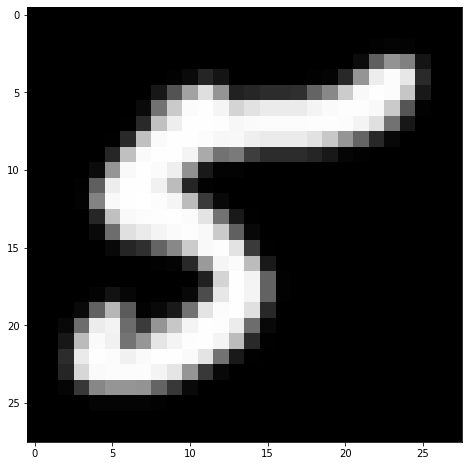

Reality:    5
Prediction: 5


In [49]:
sample_num = 10
true_vect = y_train[sample_num]
pred_vect = model.predict(x_train[sample_num:sample_num+1])
img_show(tf.reshape(x_train[sample_num:sample_num+1],[28, 28]))


labels = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','~']
#labels = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','~']
#labels = ['0','1','2','3','4','5','6','7','8','9','~']
print("Reality:    "+labels[np.argmax(true_vect)])
print("Prediction: "+labels[np.argmax(pred_vect)])

In [50]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [51]:
# calculate confusion matrix
from sklearn.metrics import confusion_matrix
preds = np.argmax(model.predict(x_test),axis=1)
trues = np.argmax(y_test,axis=1)

print(preds.shape)
print(trues.shape)
cnf_matrix = confusion_matrix(trues, preds)

(14800,)
(14800,)


Normalized confusion matrix


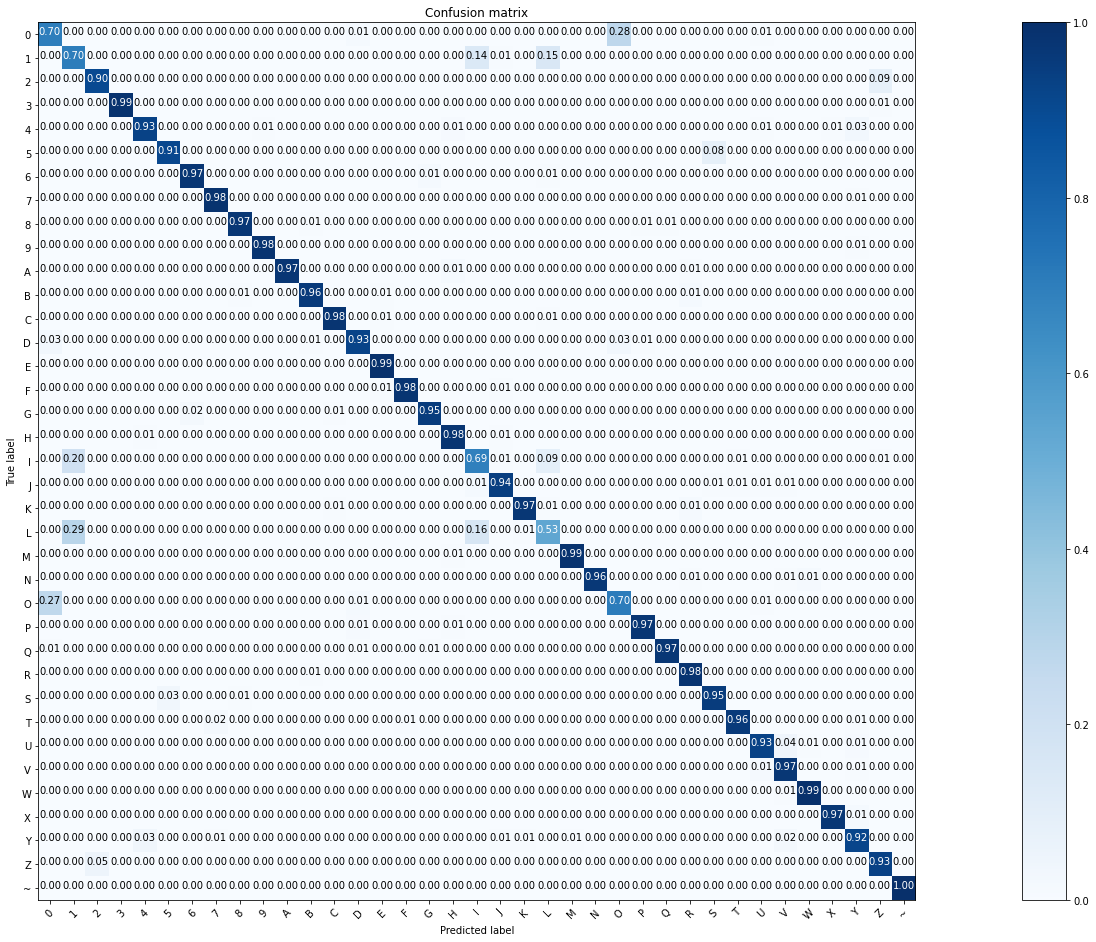

In [52]:
# Plot normalized confusion matrix
plt.figure(figsize=(30,13))
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True)

plt.show()

# Checking Processing Time for 10 Charectors Recognition

In [53]:
#rendomImages = random.sample(x_test, 10)
x_test10 = x_test[:10,:,:,:]
y_test10 = y_test[:10]
print("Labels of Orignal top 10 Charectors:")
for i in range(10):
  print(labels[np.argmax(y_test10[i])], end=" ")
print("\nLabels of Recognized top 10 Charectors:")
start_time = time.time() *1000

preds = model_best.predict(x_test10)
print(np.argmax(preds, axis=1))

end_time = time.time() * 1000
print("The computional time (ms) for the 10 Charectors is: ")
print(end_time - start_time)

# for i in range(len(x_test10)):
#   pred_vect = model.predict(charac)
  

Labels of Orignal top 10 Charectors:
9 Q X E B 3 C G 7 2 
Labels of Recognized top 10 Charectors:
[ 9 26 33 14 11  3 12 16  7  2]
The computional time (ms) for the 10 Charectors is: 
468.78662109375


## 2.3. Test model on our data (will only for the combined Letters and Digits Model)

In [54]:
# import os
# import cv2
# path_images = "/content/drive/My Drive/FD EDU Official/AI & Data Science/OCR/Upwork Mission/internal work done/test data/"

In [55]:
# cv2.imread(path_images+'roi-fn-0.png').shape

In [56]:
# np.array(plt.imread(path_images+'roi-fn-0.png')).shape

In [57]:
# img_show(np.array(plt.imread(path_images+'roi-fn-0.png')))

In [58]:
# handwritten_characters = [ ]

# for filename in sorted(os.listdir(path_images)):
#   img_ = np.array(plt.imread(path_images+filename))
#   #img_ = cv2.imread(path_images+filename)
#   handwritten_characters.append(img_)
#   print(filename)
# print(img.shape)

In [59]:
# handwritten_characters[1].shape

In [60]:
# index=7
# img_show(handwritten_characters[index])
# charac = handwritten_characters[index].reshape((-1,28,28,1))
# str(labels[np.argmax(model.predict(charac))])

In [61]:
# len(handwritten_characters)

In [62]:
# digits_labels = ['0','1','2','3','4','5','6','7','8','9','~']
# letters_labels = ['~','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# all_labels = digits_labels + letters_labels[1:] 

In [63]:

# f = plt.figure(figsize=(12,8))

# for i in range(len(handwritten_characters)):
#     sp = f.add_subplot(4, 10, i+1)
#     sp.axis('Off')
#     charac = handwritten_characters[i].reshape((-1,28,28,1))
#     pred_vect = model.predict(charac)
#     sp.set_title("Pred: "+ str(all_labels[np.argmax(pred_vect[:,:])]))
#     #if i <15: # first 15 characters are lettersac
#     #  sp.set_title("Pred: "+ str(letters_labels[np.argmax(pred_vect[:,10:])]))
#     #else:
#     #  sp.set_title("Pred: "+ str(digits_labels[np.argmax(pred_vect[:,:11])]))
#     img = handwritten_characters[i]
#     plt.imshow(img, cmap='gray')
  
